# NDSSL Processing Notebook

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import networkx as nx
import itertools
from tqdm import tqdm
import random

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.style as style 
style.use('seaborn-paper')

fontsize = 12
plt.rcParams.update({
    'font.size': fontsize, 
    'axes.labelsize': fontsize, 
    'legend.fontsize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.titlesize': fontsize
                    })

## Load the NDSSL data

### activities

**text copied from** `activities-portland-1-v2.txt':

`activities-portland-1-v2.dat` contains the activities performed by each
protoentity in the Portland data set.  The time between activities is
used to travel from activity to activity.
Each line has the following fields:

- Household Id - Household containing the person
- Person Id - Id of the person.
- Activity Id - Id of the activity, numbered sequentially for each household
- Purpose - The purpose of the activity 
        0 - Home
        1 - Work
        2 - Shop
        3 - Visit
        4 - Social/Recreation
        5 - Other
        6 - Pick up or drop off a passenger
        7 - School
        8 - College
- Start Time - Time the activity starts, in seconds past midnight
- Duration  - Duration of the activity, in seconds
- Location - Id of the location at which the activity takes place
- SubLocation - Id of the sublocation at which the activity takes place

In [2]:
activity_dict = {0:'home', 1:'work', 2:'shop', 3:'visit', 4:'social', 5:'other', 6:'transport', 7:'school', 8:'college'}

In [3]:
headerlist = ['household_id', 'person_id', 'activity_id', 'purpose', 'start_time', 'duration', 'location_id', 'sublocation_id']
filename = '../data/NDSSL data/activities-portland-1-v2/activities-portland-1-v2.dat'
activities = pd.read_csv(filename, delimiter=' ', names=headerlist)
activities

,household_id,person_id,activity_id,purpose,start_time,duration,location_id,sublocation_id
0,2000000,2000000,1,0,1,21299,10351,1000
1,2000000,2000000,2,1,21300,24599,17791,2000
2,2000000,2000000,3,1,46800,3600,18104,2001
3,2000000,2000000,4,1,51300,9900,17791,2002
4,2000000,2000000,5,0,61800,19065,10351,1000
...,...,...,...,...,...,...,...,...
8278495,2632622,3601319,1,0,1,51299,226679,1002
8278496,2632622,3601319,2,5,56700,3600,176571,4002
8278497,2632622,3601319,3,0,62100,4500,226679,1002
8278498,2632622,3601319,4,4,66899,8700,198896,4002


In [4]:
print('number of unique individuals: %i' %len(np.unique(activities['person_id'])))
print('number of activities: %i' %len(activities))

number of unique individuals: 1601330
number of activities: 8278500


### contacts

**text copied from** `contact-portland-1-v2.txt':

`contact-portland-1-v2.dat` is a static person-person contact graph,
including the sublocation model. That is, contacts only exist between
people at the same location and sublocation.

Each line contains one contact between a pair of people. Note that two
people may be connected by more than one edge if they share several
activity types.  Contacts are bi-directional (i.e., if person A has a
contact with person B, then B has a contact of the same length with
A).  Only one direction is represented in the file, such that Person
Id 1 is always greater than Person Id 2.

Each line has the following fields:

- Person Id 1 - Id of the first person of the contact pair
- Purpose 1 - Activity purpose of the first person
- Person Id 2 - Id of the second person of the contact pair
- Purpose 2 - Activity purpose of the second person
- Contact Duration - Time in seconds of the contact

In [5]:
headerlist = ['person_id1', 'activity1', 'person_id2', 'activity2', 'duration']
filename = '../data/NDSSL data/contact-portland-1-v2/contact-portland-1-v2.dat'
contacts = pd.read_csv(filename, delimiter=' ', names=headerlist)
contacts

,person_id1,activity1,person_id2,activity2,duration
0,2000001,0,2000000,0,39298
1,2000002,0,2000000,0,45898
2,2000002,0,2000001,0,45298
3,2000004,0,2000003,0,50099
4,2000005,0,2000003,0,50099
...,...,...,...,...,...
19681816,3601328,1,3517985,1,5400
19681817,3601329,0,3601328,0,74278
19681818,3601329,2,3486224,2,179
19681819,3601329,3,3378614,4,600


In [6]:
print('number of unique individuals: %i' %(len(np.unique(np.concatenate((np.asarray(contacts['person_id1']), np.asarray(contacts['person_id2'])))))))
print('number of person-person contacts: %i' %len(contacts))

number of unique individuals: 1575861
number of person-person contacts: 19681821


The fact there are fewer unique individuals in the contact data than in the activity data suggests that some people are isolates, and do not come into contact with any other people.

### demographics - household

**text copied from** `demographics-household-portland-1-v2.txt' (note they refer to a v1 file with a different filename):

`demographics-portland-1-v1.dat` contains demographics for each
ProtoEntity in the Portland data set. Each line has the following fields:

- Household Id - Household containing the person
- Income Household income range in US dollars
          1   0 - 4,999
          2   5000 - 9,999
          3   10,000 - 14,999
          4   15,000 - 19,999,
          5   20,000 - 24,999
          6   25,000 - 29,999
          7   30,000 - 34,999
          8   35,000 - 39,999
          9   40,000 - 44,999
          10  45,000 - 49,999
          11  50,000 - 54,999
          12  55,000 - 59,999
          13  >= 60,000
          14  < 0
- Household Size - Total number of people in the household
- Home Location Id - Location Id for the home in which this household resides
- Home Sublocation Id - Sublocation of the home in which this household resides
- Vehicles - Number of vehicles in the household
- Workers - Number of household members who work

In [7]:
headerlist = ['household_id', 'household_income', 'household_size', 'home_location_id', 'home_sublocation_id', 'household_vehicles', 'household_workers']
filename = '../data/NDSSL data/demographics-household-portland-1-v2/demographics-household-portland-1-v2.dat'
demographics_household = pd.read_csv(filename, delimiter=' ', names=headerlist)
demographics_household

,household_id,household_income,household_size,home_location_id,home_sublocation_id,household_vehicles,household_workers
0,2000000,12,3,10351,1000,2,2
1,2000001,13,6,3816,1000,5,1
2,2000002,13,2,4082,1000,2,1
3,2000003,13,3,244828,1000,3,2
4,2000004,13,2,10677,1000,2,2
...,...,...,...,...,...,...,...
632621,2632621,11,4,198490,1000,2,1
632622,2632622,7,4,226679,1002,3,2
632623,2632623,7,4,181994,1012,3,2
632624,2632624,10,4,228198,1004,2,2


### demographics - person

**text copied from** `demographics-person-portland-1-v2.txt' (note they refer to a v1 file with a different filename):

`demographics-portland-1-v1.dat` contains demographics for each ProtoEntity in the Portland data set. Each line has the following fields:

- Person Id - Id of the person.
- Household Id - Household containing the person.  Household demographics can be found in the household demographics file.
- Age - Age of the person, in years
- Gender 
       1 Male
       2 Female
- Worker - Worker status
       1 Works
       2 Does not work
- Relationship - Relationship to the head of household\



In [8]:
headerlist = ['person_id', 'household_id', 'age', 'gender', 'worker', 'relationship']
filename = '../data/NDSSL data/demographics-household-portland-1-v2/demographics-person-portland-1-v2.dat'
demographics_person = pd.read_csv(filename, delimiter=' ', names=headerlist)
demographics_person

,person_id,household_id,age,gender,worker,relationship
0,2509159,2201175,42,1,1,1
1,2509160,2201175,43,2,1,1
2,2509161,2201175,17,1,2,2
3,2509162,2201176,41,1,1,1
4,2509163,2201176,11,1,2,2
...,...,...,...,...,...,...
1601325,3600563,2632365,4,2,2,2
1601326,3600564,2632365,1,1,2,2
1601327,3600565,2632365,0,1,2,2
1601328,3600835,2632457,60,2,1,1


### locations

**text copied from** `locations-portland-1-v2.txt` (note they refer to a v1 file with a different filename):

`locations-portland-1-v1.dat` contains geographic information for each ProtoLocation in the Portland data set.

Each line has the following fields:
- Location Id - id of the location
- Y - offset from origin in meters
- X - offset from origin in meters


In [9]:
headerlist = ['location_id', 'ycoord', 'xcoord']
filename = '../data/NDSSL data/locations-portland-1-v2/locations-portland-1-v2.dat'
locations = pd.read_csv(filename, delimiter=' ', names=headerlist)
locations

,location_id,ycoord,xcoord
0,172042,527523.0,5033908.5
1,96304,527186.2,5036353.0
2,173767,527573.3,5033943.5
3,89545,527376.2,5036657.5
4,243420,527144.6,5033981.0
...,...,...,...
243418,228081,532835.1,5051936.0
243419,228083,532907.8,5051916.0
243420,228084,532907.7,5051936.0
243421,226581,531449.4,5050977.5


Also load the location lookup table

In [10]:
headerlist = ['location_id', 'xcoord', 'ycoord', 'longitude', 'latitude', 'zipcode']
filename = '../data/NDSSL data/locations-portland-1-v2/location.Id.lookup.csv'
location_lookup = pd.read_csv(filename, delimiter=',', header=0)
location_lookup

,Location.Id,X,Y,lon,lat,zipcode
0,172042,527523.0,5033908.5,-122.647974,45.458160,97202
1,96304,527186.2,5036353.0,-122.652147,45.480176,97202
2,173767,527573.3,5033943.5,-122.647329,45.458473,97202
3,89545,527376.2,5036657.5,-122.649699,45.482910,97202
4,243420,527144.6,5033981.0,-122.652810,45.458828,97202
...,...,...,...,...,...,...
243418,228081,532835.1,5051936.0,-122.578823,45.620193,98664
243419,228083,532907.8,5051916.0,-122.577892,45.620010,98664
243420,228084,532907.7,5051936.0,-122.577892,45.620190,98664
243421,226581,531449.4,5050977.5,-122.596659,45.611630,97254


In [11]:
## create a dictionary mapping location ids to zipcodes
zip_dict = {location_lookup['Location.Id'].iloc[i]: location_lookup['zipcode'].iloc[i] for i in range(len(location_lookup))}

## Convert NDSSL data into attributed matrix

Attributed graphs consist of an adjacency matrix, a node attribute matrix, and an edge attribute matrix.
- Adjacency matrix **A**:
    - This is straightforward - the (undirected) links will be just those given by the contact data file
- Node feature matrix **V**:
    - Here I think we want to combine the demographic data for the node and the household. 
    - We'll just have to be mindful of the fact that people in the same household have the same household demographic data. 
    - The features to include are:
        - person id
        - household id
        - age
        - gender
        - worker
        - relationship
        - household income
        - household size
        - home location id
        - home sublocation id
        - vehicles (in household)
        - workers (in household)
- Edge feature matrix **E**:
    - For each contact we have some additional information:
        - activity id of person1
        - activity id of person2
        - duration

For a given task, I expect that only some of this information will be useful, in which case we would want to drop some fields. Also, one last piece of information would be to convert the location id's into actual x,y coordinates and zip-codes. **I'm not sure what the sub-locations mean - I can't find any lookup table in the data folder**.

### edge list

In [12]:
edge_list_filename = 'data/NDSSL data/raw/edge_list.csv'

## if file already exists, load, otherwise, generate from raw NDSSL data
try:
    edge_list = pd.read_csv(edge_list_filename)
except:
    edge_list = pd.DataFrame()
    edge_list['person_id1'] = contacts['person_id1']
    edge_list['person_id2'] = contacts['person_id2']
    edge_list.to_csv(edge_list_filename, encoding='utf-8', index=False)
    
edge_list

,person_id1,person_id2
0,2000001,2000000
1,2000002,2000000
2,2000002,2000001
3,2000004,2000003
4,2000005,2000003
...,...,...
19681816,3601328,3517985
19681817,3601329,3601328
19681818,3601329,3486224
19681819,3601329,3378614


### node attribute matrix 

In [13]:
zip_dict;

In [14]:
node_attributes_filename = 'data/NDSSL data/raw/node_attributes.csv'

## if file already exists, load, otherwise, generate from raw NDSSL data
try:
    node_attributes = pd.read_csv(node_attributes_filename)
except:
    node_attributes = demographics_person.copy()

    ## add blank entries for the household demographic data
    node_attributes['household_income'] = len(node_attributes)*['NA']
    node_attributes['household_size'] = len(node_attributes)*['NA']
    #node_attributes['home_location_id'] = len(node_attributes)*['NA']
    #node_attributes['home_sublocation_id'] = len(node_attributes)*['NA']
    node_attributes['zipcode'] = len(node_attributes)*['NA']
    node_attributes['household_vehicles'] = len(node_attributes)*['NA']
    node_attributes['household_workers'] = len(node_attributes)*['NA'] 
    
    ## add in the household demographic data, cell by cell
    for i in range(len(node_attributes)):
        tmp = demographics_household[demographics_household['household_id'] == node_attributes['household_id'].iloc[i]].copy()
        node_attributes.at[i, 'household_income'] = tmp['household_income'].iloc[0]
        node_attributes.at[i, 'household_size'] = tmp['household_size'].iloc[0]
        #node_attributes.at[i, 'home_location_id'] = tmp['home_location_id'].iloc[0]
        #node_attributes.at[i, 'home_sublocation_id'] = tmp['home_sublocation_id'].iloc[0]
        node_attributes.at[i, 'zipcode'] = zip_dict[tmp['home_location_id'].iloc[0]]        
        node_attributes.at[i, 'household_vehicles'] = tmp['household_vehicles'].iloc[0]
        node_attributes.at[i, 'household_workers'] = tmp['household_workers'].iloc[0]
    
    ## save
    node_attributes.to_csv(node_attributes_filename, encoding='utf-8', index=False)

node_attributes

,person_id,household_id,age,gender,worker,relationship,household_income,household_size,zipcode,household_vehicles,household_workers
0,2509159,2201175,42,1,1,1,13,3,97201,3,2
1,2509160,2201175,43,2,1,1,13,3,97201,3,2
2,2509161,2201175,17,1,2,2,13,3,97201,3,2
3,2509162,2201176,41,1,1,1,11,2,97201,3,1
4,2509163,2201176,11,1,2,2,11,2,97201,3,1
...,...,...,...,...,...,...,...,...,...,...,...
1601325,3600563,2632365,4,2,2,2,6,8,98604,2,1
1601326,3600564,2632365,1,1,2,2,6,8,98604,2,1
1601327,3600565,2632365,0,1,2,2,6,8,98604,2,1
1601328,3600835,2632457,60,2,1,1,5,1,98622,1,1


In [15]:
## check that all the 'NA' entries are gone?
print(np.sum(node_attributes['household_income'] == 'NA'))
print(np.sum(node_attributes['household_size'] == 'NA'))
#print(np.sum(node_attributes['home_location_id'] == 'NA'))
#print(np.sum(node_attributes['home_sublocation_id'] == 'NA'))
print(np.sum(node_attributes['zipcode'] == 'NA'))
print(np.sum(node_attributes['household_vehicles'] == 'NA'))
print(np.sum(node_attributes['household_workers'] == 'NA'))

0
0
0
0
0


In [16]:
## check that every household is present in the node attributes
set(list(node_attributes['household_id'])) == set(list(demographics_household['household_id']))

True

The node feature is a categorical vector, and therefore there is a finite number of possible feature vectors. Let's count how many there are. To do so, we should ignore the person_id field. We may also want to ignore other fields.

In [17]:
print('household_id:', len(np.unique(node_attributes['household_id'])))
print('age:', len(np.unique(node_attributes['age'])))
print('gender:', len(np.unique(node_attributes['gender'])))
print('worker:', len(np.unique(node_attributes['worker'])))
print('relationship:', len(np.unique(node_attributes['relationship'])))
print('household_income:', len(np.unique(node_attributes['household_income'])))
print('household_size:', len(np.unique(node_attributes['household_size'])))
print('zipcode:', len(np.unique(node_attributes['zipcode'])))
print('household_vehicles:', len(np.unique(node_attributes['household_vehicles'])))
print('household_workers:', len(np.unique(node_attributes['household_workers'])))

household_id: 632626
age: 91
gender: 2
worker: 2
relationship: 4
household_income: 14
household_size: 14
zipcode: 117
household_vehicles: 8
household_workers: 9


### edge attribute matrix 

The edge attribute matrix is already formed, and just corresponds to the contact matrix. In order to keep with a simple naming convention, I'll re-save this under the name `edge_attributes.csv`. Also, I'll change the order of the columns so that first two columns of this matrix are just the edge list.

In [18]:
edge_attribute_filename = 'data/NDSSL data/raw/edge_attributes.csv'

## if file already exists, load, otherwise, generate from raw NDSSL data
try:
    edge_attributes = pd.read_csv(edge_attribute_filename)
except:
    edge_attributes = contacts.copy()
    edge_attributes = edge_attributes[['person_id1', 'person_id2', 'activity1', 'activity2', 'duration']]
    edge_attributes.to_csv(edge_attribute_filename, encoding='utf-8', index=False)

edge_attributes

,person_id1,person_id2,activity1,activity2,duration
0,2000001,2000000,0,0,39298
1,2000002,2000000,0,0,45898
2,2000002,2000001,0,0,45298
3,2000004,2000003,0,0,50099
4,2000005,2000003,0,0,50099
...,...,...,...,...,...
19681816,3601328,3517985,1,1,5400
19681817,3601329,3601328,0,0,74278
19681818,3601329,3486224,2,2,179
19681819,3601329,3378614,3,4,600


## Data Exploration

First, let's perform an important check: is everyone in the same household connected? 

This check takes forever to run, so I only will run it once. The result is that every household member is connected in the edge list.

In [19]:
## b/c this takes a long time to run, only run it if the flag is set to True
if False:
    
    count = 0
    
    ## loop over all households
    for i in tqdm(range(len(demographics_household))):

        ## get the nodes assigned to the household
        household = node_attributes[node_attributes['household_id'] == demographics_household['household_id'].iloc[i]]

        ## form a tuple of node pairs, and put the larger node id first
        tuple_list = list(itertools.combinations(household['person_id'], 2))
        household_edges = pd.DataFrame([tup[::-1] for tup in tuple_list], columns=['person_id1', 'person_id2'])

        ## for every pair, check that the edge is present in the edge_list
        for j in range(len(household_edges)):
            if not (edge_list == household_edges.iloc[j]).all(1).any():
                count += 1
            if count > 0:
                print('problem!')
                break

    print('number of household pairs not in edge list: %i' %count)        

### Network Structure

In [20]:
G = nx.Graph()
G.add_edges_from([tuple(x) for x in edge_list.values])

First, let's check the number of nodes and edges. We again see that the number of nodes is fewer than in the node attribute data - indicating that there are isolate nodes who have no contact with anyone else.

In [21]:
print('number of edges: %i' %G.number_of_edges())
print('number of nodes: %i' %G.number_of_nodes())
print('number of isolate nodes: %i' %(1601330 - G.number_of_nodes()))

number of edges: 19481626
number of nodes: 1575861
number of isolate nodes: 25469


In [22]:
print('density: %.2e' % nx.density(G))
print('edges/nodes (not counting isolates): %.2f' % (G.number_of_edges()/G.number_of_nodes()))

density: 1.57e-05
edges/nodes (not counting isolates): 12.36


In [23]:
def edge_weight_and_type(G):
    
    edges = np.sort(list(G.edges()))
    edge_weights = []
    edge_types = {}
    for i in range(len(edges)):
        edge = edges[i]
        edge_attribute = edge_attributes[(edge_attributes['person_id1'] == edge[1]) & (edge_attributes['person_id2'] == edge[0])]
        edge_weights.append(edge_attribute['duration'].values[0])
        edge_types[(edge[1], edge[0])] = activity_dict[edge_attribute['activity1'].values[0]] + '|' + activity_dict[edge_attribute['activity2'].values[0]]
    
    return np.asarray(edge_weights), edge_types

Visualize the neighborhoods of a random selection of nodes

In [24]:
## set a random seed
seed = 201
random.seed(a=seed)
np.random.seed(seed)

## pick the node
root = random.choice(list(G.nodes))

## extract the 1-degree neighborhood graph
edges1 = nx.bfs_edges(G, root, depth_limit=1)
nodes1 = [root] + [v for u, v in edges1]
subgraph1 = G.subgraph(nodes1)
edge_weights1, edge_types1 = edge_weight_and_type(subgraph1)

## extract the 2-degree neighborhood graph
edges2 = nx.bfs_edges(G, root, depth_limit=2)
nodes2 = [root] + [v for u, v in edges2]
subgraph2 = G.subgraph(nodes2)
pos2 = nx.spring_layout(subgraph2)
edge_weights2, edge_types2 = edge_weight_and_type(subgraph2)

## color wheel
cm = plt.get_cmap('gist_rainbow')
edge_color_key = {}
labels = list(set(list(edge_types2)))
for i in range(len(labels)):
    edge_color_key[labels[i]] = matplotlib.colors.rgb2hex(cm(i/len(labels))[:3])
    
edge_colors1 = [edge_color_key[list(edge_types1.keys())[i]] for i in range(len(edge_types1))]
edge_colors2 = [edge_color_key[list(edge_types2.keys())[i]] for i in range(len(edge_types2))]

In [25]:
node_size_key = {0:40, 1:40, 2:12}
node_color_key = {0:'red', 1:'blue', 2:'green'}
node_colors1 = [ node_color_key[nx.shortest_path_length(subgraph1, source=root, target=list(subgraph1.nodes())[i])] \
               for i in range(len(list(subgraph1.nodes())))]
node_colors2 = [ node_color_key[nx.shortest_path_length(subgraph2, source=root, target=list(subgraph2.nodes())[i])] \
               for i in range(len(list(subgraph2.nodes())))]

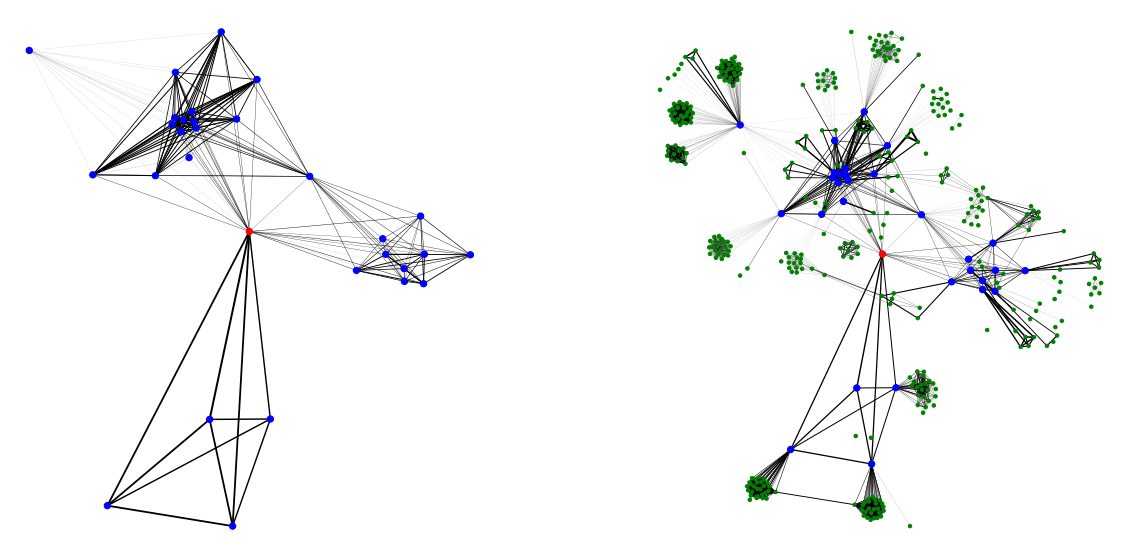

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
fig.subplots_adjust(wspace=0.3)

## 1-neighbor plot
nx.draw(subgraph1, pos2, linewidths=1, ax=ax[0], node_size=40, edge_color='k', node_color=node_colors1, \
        width=2*edge_weights1/np.max(edge_weights1))
#nx.draw_networkx_edge_labels(subgraph, pos, width=1, linewidths=1, font_size=10, font_color='black', ax=ax[0]);

## 2-neighbor plot
node_sizes = [ node_size_key[nx.shortest_path_length(subgraph2, source=root, target=list(subgraph2.nodes())[i])] for i in range(len(list(subgraph2.nodes())))]
nx.draw(subgraph2, pos2, linewidths=1, ax=ax[1], node_size=node_sizes, edge_color='k', node_color=node_colors2, \
        width=2*edge_weights2/np.max(edge_weights2))
#nx.draw_networkx_edge_labels(subgraph, pos, width=1, linewidths=1, font_size=10, font_color='black', ax=ax[1]);

## legend
#handles = []
#for i in range(len(list(edge_color_key.values()))):
#    color = list(edge_color_key.values())[i]
#    label = list(edge_color_key.keys())[i]    
#    handles.append(mpatches.Patch(color=color, label=label))
#fig.legend(handles=handles, loc=(0.4, 0.25), ncol=2)

plt.savefig("figures/NDSSL_egograph.pdf", bbox_inches='tight')
plt.show()

Make the same 1-neighborhood lot, but now label the interactions:

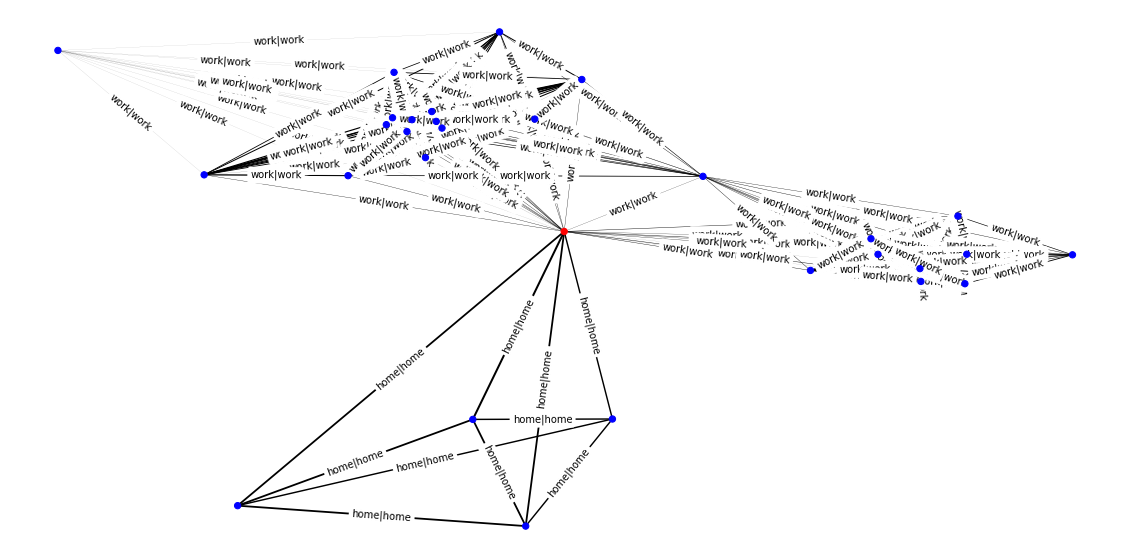

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
fig.subplots_adjust(wspace=0.3)

## 1-neighbor plot
nx.draw(subgraph1, pos2, linewidths=1, ax=ax, node_size=40, edge_color='k', node_color=node_colors1, \
        width=2*edge_weights1/np.max(edge_weights1))
nx.draw_networkx_edge_labels(subgraph1, pos2, edge_labels=edge_types1, label_pos=0.5, font_size=10)

plt.show()

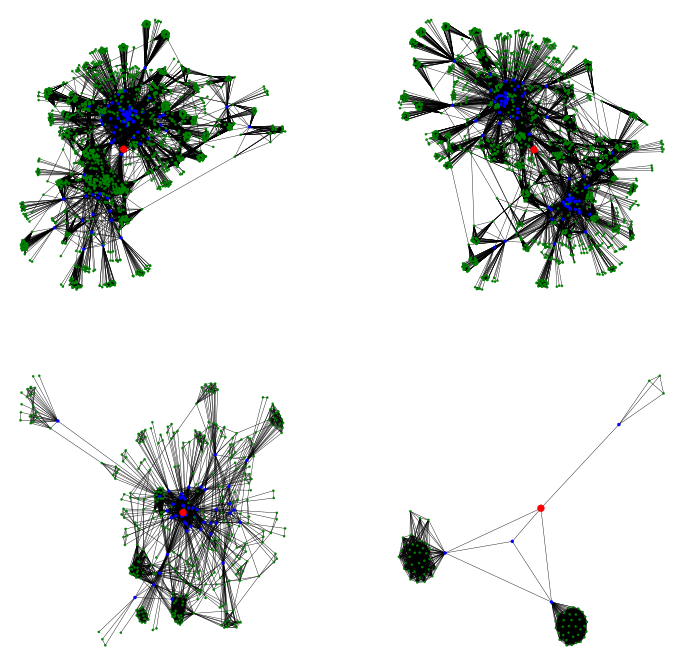

In [28]:
## set a random seed
random.seed(a=123)
np.random.seed(123)

## the size and color of the nodes is determined by their distance from the root node
color_key = {0:'red', 1:'blue', 2:'green'}
size_key = {0:50, 1:10, 2:5}

n1, n2 = 2, 2
fig, axarr = plt.subplots(n1, n2, figsize=(6*n2,6*n1))
fig.subplots_adjust(wspace=0.3)
#st = plt.suptitle('Individual Demographic Data', fontsize=16)

for i in range(n1):
    for j in range(n2):
        
        root = random.choice(list(G.nodes))
        edges = nx.bfs_edges(G, root, depth_limit=2)
        nodes = [root] + [v for u, v in edges]
        subgraph = G.subgraph(nodes)
        node_colors = [ color_key[nx.shortest_path_length(subgraph, source=root, target=list(subgraph.nodes())[i])] \
                       for i in range(len(list(subgraph.nodes())))]
        node_sizes = [ size_key[nx.shortest_path_length(subgraph, source=root, target=list(subgraph.nodes())[i])] for i in range(len(list(subgraph.nodes())))]
        nx.draw_spring(subgraph, node_size=node_sizes, width=0.4, node_color=node_colors, ax=axarr[i,j])
        
plt.show()

#### Degree Distribution

**Terminology**
- degree of node $i$: $k_i$
- degree sequence: $(k_1, k_2, ..., k_N)$
- empirical degree probability distribution: $p_k =$ (number of nodes with degree $k$)/$N$

In [29]:
degree_sequence = np.asarray(sorted([d for n, d in G.degree()], reverse=False))

print('mean degree %.2f' % np.mean(degree_sequence))
print('mode degree %i' % stats.mode(degree_sequence)[0][0])

mean degree 24.73
mode degree 3


First let's plot the degree histogram

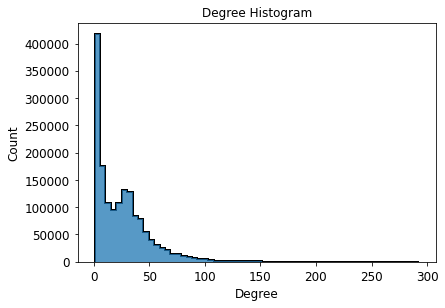

In [30]:
fig, ax = plt.subplots()
plt.hist(degree_sequence, bins=60, alpha=1, color='k', histtype='step', linewidth=2)
plt.hist(degree_sequence, bins=60, alpha=0.75, linewidth=2)
#plt.yscale('log')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

Let's try plotting the degree/count directly, not as a histogram:

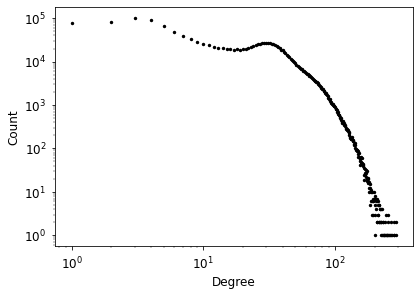

In [31]:
from collections import Counter
degree_counter = Counter(degree_sequence)

fig, ax = plt.subplots()
plt.scatter(list(degree_counter.keys()), list(degree_counter.values()), alpha=1, color='k', linewidth=2, s=2, marker='o')
plt.xscale('log')
plt.yscale('log')
#plt.title("Degree")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

Can we explain the bump in degrees? Let's break down the degree sequence by employment status. Note that the list of nodes in the `node_attributes` is greater than the list of nodes in the graph G because the graph does not include so-called isolate nodes.

In [32]:
node_dict = dict(G.degree())

In [33]:
employed_nodes = node_attributes[node_attributes['worker'] == 1]['person_id'].values
unemployed_nodes = node_attributes[node_attributes['worker'] == 2]['person_id'].values

unemployed_degrees = []
for i in range(len(unemployed_nodes)):
    try:
        unemployed_degrees.append(node_dict[unemployed_nodes[i]])
    except:
        pass
    
employed_degrees = []
for i in range(len(employed_nodes)):
    try:
        employed_degrees.append(node_dict[employed_nodes[i]])
    except:
        pass

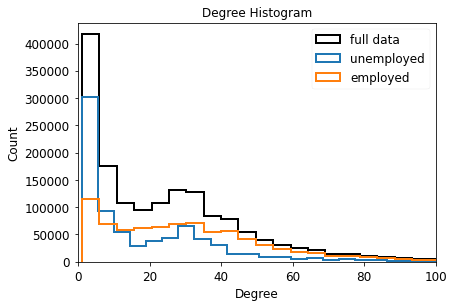

In [34]:
fig, ax = plt.subplots()

plt.hist(degree_sequence, bins=60, alpha=1, color='k', histtype='step', linewidth=2, label='full data')
plt.hist(unemployed_degrees, bins=60, alpha=1, histtype='step', linewidth=2, label='unemployed')
plt.hist(employed_degrees, bins=60, alpha=1, histtype='step', linewidth=2, label='employed')

#plt.yscale('log')
plt.xlim(0,100)
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.legend(fontsize=12)
plt.show()

Next, look at the CDF $P_k$, the fraction of of nodes with degree k or greater:

$$ P_k = \sum_{k' = k}^{\infty} p_{k'} \,. $$

This is related to the rank via $P_k = r/N$.

If the degree distribution obeys a power law, i.e. $p_k = C k^{-\alpha}$, for some constant $C$, then $P_k$ also obeys a power law:

$$ P_k = C \sum_{k' = k}^{\infty} (k')^{-\alpha} \simeq C \int_k^{\infty} (k')^{-\alpha} d k' = \frac{C}{\alpha - 1} k^{-(\alpha-1)} \,. $$

In [35]:
rank = {i+1:degree_sequence[-(i+1)] for i in range(len(degree_sequence))}
Pk = np.asarray(list(rank.keys()))/G.number_of_nodes()

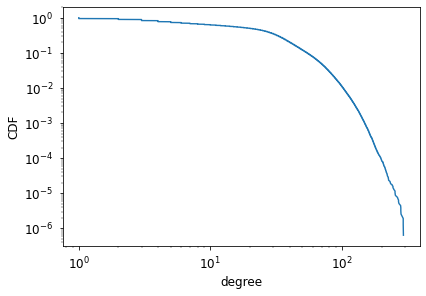

In [36]:
plt.loglog(degree_sequence, -np.sort(-Pk))
plt.xlabel('degree')
plt.ylabel('CDF')
plt.show()

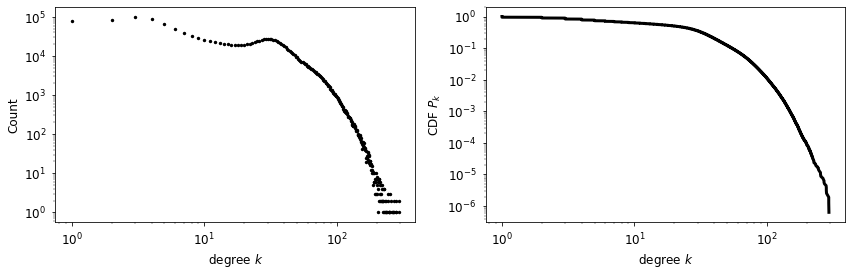

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

#hist, ex = np.histogram(dat, bins = bins)
#ax1.fill_between(bins[:-1], hist, lw=0.0, step="post")

ax[0].scatter(list(degree_counter.keys()), list(degree_counter.values()), alpha=1, color='k', linewidth=2, s=2, marker='o')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel("Count")
ax[0].set_xlabel(r"degree $k$")

ax[1].loglog(degree_sequence, -np.sort(-Pk), linewidth=3, color='k')
ax[1].set_xlabel(r'degree $k$')
ax[1].set_ylabel(r'CDF $P_k$')

plt.tight_layout()
plt.savefig("figures/degree_dist.pdf", bbox_inches='tight', pad_inches = 0, transparent = True)
plt.show()

Analyze whether this distribution has a powerlaw tail.

In [38]:
import powerlaw
results = powerlaw.Fit(degree_sequence, discrete=True)
print('alpha = ', results.power_law.alpha)
print('xmin = ', results.power_law.xmin)
R, p = results.distribution_compare('power_law', 'lognormal')
print(R, p)

Calculating best minimal value for power law fit
/home/gavin/anaconda3/envs/pygeo/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in true_divide
  (CDF_diff**2) /
/home/gavin/anaconda3/envs/pygeo/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: divide by zero encountered in true_divide
  (CDF_diff**2) /


alpha =  6.5499254260915105
xmin =  96.0
-240.2228838764578 1.5984757468662288e-35


From [the powerlaw documentation](https://pythonhosted.org/powerlaw/), `distribution_compare` function returns

R : float, Loglikelihood ratio of the two distributions’ fit to the data. If greater than 0, the first distribution is preferred. If less than 0, the second distribution is preferred.

p : float, Significance of R

So, the data is not well explained by a power law, even in the limited region found by the fit (i.e. degree > 96). The data in that region is better described by a lognormal distribution. Also, even if this test had come out with the opposite answer, only a very small fraction of the data lies in the region degree > 96, and so even in that case we would not be able to ascribe much significance to the positive result.

#### Average age of neighbors

In [39]:
# avg_age = {}
# for i in range(np.min(node_attributes['person_id'].values), np.max(node_attributes['person_id'].values)+1):
#     try:
#        neighbors = np.asarray([n for n in G.neighbors(i)])
#        avg_age[i - np.min(node_attributes['person_id'].values)] = np.mean(node_attributes.loc[node_attributes['person_id'].isin(neighbors)]['age'])
#    # for nodes not in the graph (i.e. isolates, define the average age of their neigbhors to be 0
#    except:
#        avg_age[i - np.min(node_attributes['person_id'].values)] = 0
#        #print('whoopsies')

#### Connected Components

In [40]:
connected_components_sizes = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print('number of connected components %i' % len(connected_components_sizes))

number of connected components 14902


In [41]:
from collections import Counter
c = Counter(connected_components_sizes) 
print(c)

Counter({2: 10904, 3: 2522, 4: 1048, 5: 262, 6: 107, 7: 47, 8: 7, 9: 3, 1539920: 1, 11: 1})


In [42]:
largest_cc = max(nx.connected_components(G), key=len)
giant_component = G.subgraph(largest_cc)

Examine some distance measures for the giant component

In [43]:
#print('graph diameter = %i' %nx.diameter(giant_component))

### Node Attribute Data

In [44]:
node_attributes

,person_id,household_id,age,gender,worker,relationship,household_income,household_size,zipcode,household_vehicles,household_workers
0,2509159,2201175,42,1,1,1,13,3,97201,3,2
1,2509160,2201175,43,2,1,1,13,3,97201,3,2
2,2509161,2201175,17,1,2,2,13,3,97201,3,2
3,2509162,2201176,41,1,1,1,11,2,97201,3,1
4,2509163,2201176,11,1,2,2,11,2,97201,3,1
...,...,...,...,...,...,...,...,...,...,...,...
1601325,3600563,2632365,4,2,2,2,6,8,98604,2,1
1601326,3600564,2632365,1,1,2,2,6,8,98604,2,1
1601327,3600565,2632365,0,1,2,2,6,8,98604,2,1
1601328,3600835,2632457,60,2,1,1,5,1,98622,1,1


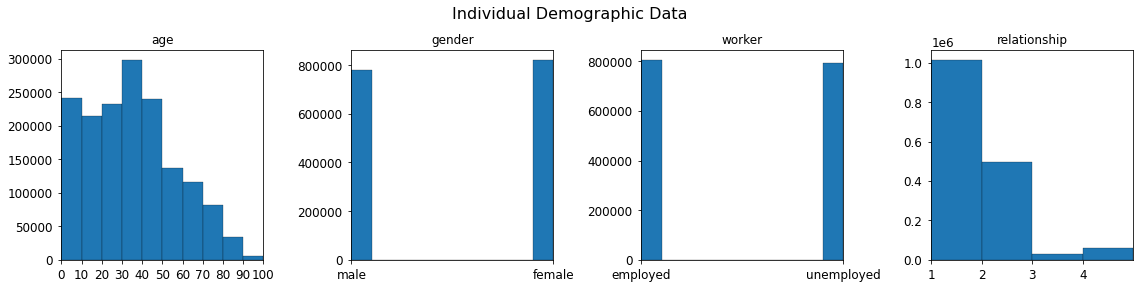

In [45]:
fig, axarr = plt.subplots(1, 4, figsize=(16,4))
fig.subplots_adjust(wspace=0.3)

st = plt.suptitle('Individual Demographic Data', fontsize=16)

## age
bins = [0,10,20,30,40,50,60,70,80,90,100]
axarr[0].hist(node_attributes['age'].values, density=False, bins=bins, edgecolor='black')
axarr[0].set_title('age')
#bins = np.arange(1, node_attributes['age'].values.max() + 0.5) - 0.5
axarr[0].set_xticks(bins)
axarr[0].set_xlim([0, 100])

## gender
bins = np.arange(node_attributes['gender'].values.min(), node_attributes['gender'].values.max() + 1)
axarr[1].hist(node_attributes['gender'].values, density=False, edgecolor='black')
axarr[1].set_title('gender')
axarr[1].set_xticks(bins)
axarr[1].set_xticklabels(['male', 'female'])
axarr[1].set_xlim([node_attributes['gender'].values.min(), node_attributes['gender'].values.max()])

## worker
bins = np.arange(node_attributes['worker'].values.min(), node_attributes['worker'].values.max() + 1)
axarr[2].hist(node_attributes['worker'].values, density=False, edgecolor='black')
axarr[2].set_title('worker')
axarr[2].set_xticks(bins)
axarr[2].set_xticklabels(['employed', 'unemployed'])
axarr[2].set_xlim([node_attributes['worker'].values.min(), node_attributes['worker'].values.max()])

## relationship
bins = np.arange(node_attributes['relationship'].values.min(), node_attributes['relationship'].values.max() + 2)
axarr[3].hist(node_attributes['relationship'].values, bins=bins, density=False, edgecolor='black')
axarr[3].set_title('relationship')
axarr[3].set_xticks(bins[0:-1])
axarr[3].set_xlim([node_attributes['relationship'].values.min(), node_attributes['relationship'].values.max()+1])

plt.tight_layout()

# shift subplots down:
st.set_y(1)
fig.subplots_adjust(top=0.85)

## save and display
plt.savefig("figures/individual_histograms.pdf", bbox_inches='tight')
plt.show()

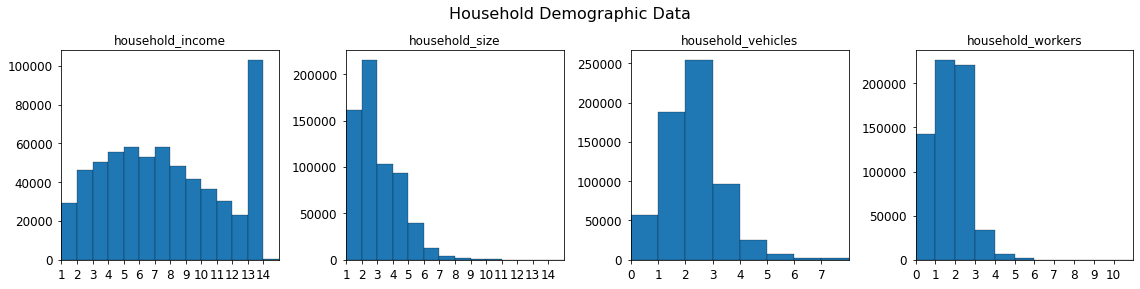

In [46]:
fig, axarr = plt.subplots(1, 4, figsize=(16,4))
fig.subplots_adjust(wspace=0.3)

st = plt.suptitle('Household Demographic Data', fontsize=16)

## household_income
bins = np.arange(demographics_household['household_income'].values.min(), demographics_household['household_income'].values.max() + 2)
axarr[0].hist(demographics_household['household_income'].values, bins=bins, density=False, edgecolor='black')
axarr[0].set_title('household_income')
axarr[0].set_xticks(bins[:-1])
axarr[0].set_xlim([demographics_household['household_income'].values.min(), demographics_household['household_income'].values.max()+1])

## household_size
bins = np.arange(demographics_household['household_size'].values.min(), demographics_household['household_size'].values.max() + 2)
axarr[1].hist(demographics_household['household_size'].values, bins=bins, density=False, edgecolor='black')
axarr[1].set_title('household_size')
axarr[1].set_xticks(bins[:-1])
axarr[1].set_xlim([demographics_household['household_size'].values.min(), demographics_household['household_size'].values.max()+1])

## household_vehicles
bins = np.arange(demographics_household['household_vehicles'].values.min(), demographics_household['household_vehicles'].values.max() + 2)
axarr[2].hist(demographics_household['household_vehicles'].values, bins=bins, density=False, edgecolor='black')
axarr[2].set_title('household_vehicles')
axarr[2].set_xticks(bins[:-1])
axarr[2].set_xlim([demographics_household['household_vehicles'].values.min(), demographics_household['household_vehicles'].values.max()+1])

## household_workers
bins = np.arange(demographics_household['household_workers'].values.min(), demographics_household['household_workers'].values.max() + 2)
axarr[3].hist(demographics_household['household_workers'].values, bins=bins, density=False, edgecolor='black')
axarr[3].set_title('household_workers')
axarr[3].set_xticks(bins[:-1])
axarr[3].set_xlim([demographics_household['household_workers'].values.min(), demographics_household['household_workers'].values.max()+1])

plt.tight_layout()

# shift subplots down:
st.set_y(1)
fig.subplots_adjust(top=0.85)

## save and display
plt.savefig("figures/household_histograms.pdf", bbox_inches='tight')
plt.show()

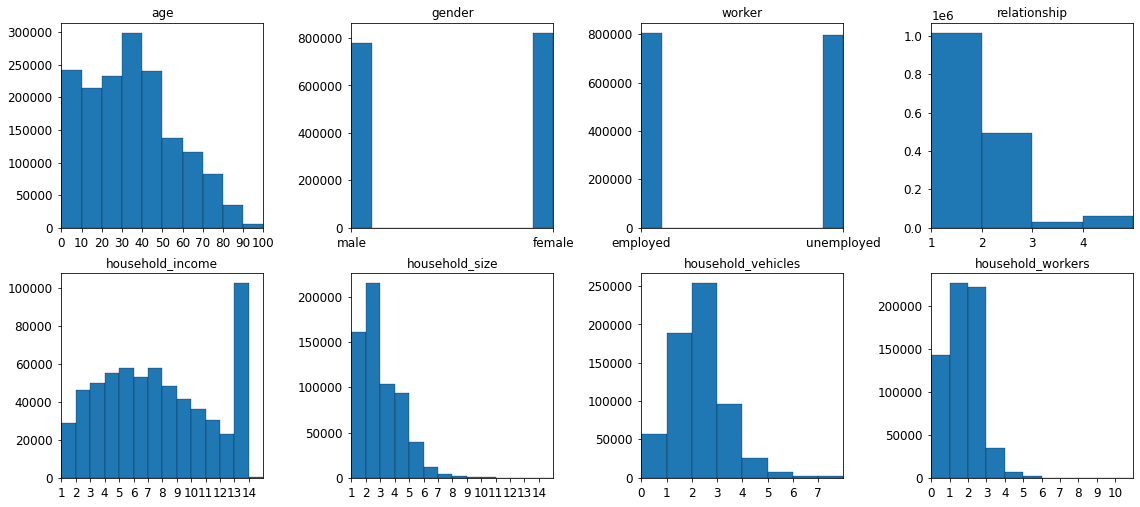

In [47]:
fig, axarr = plt.subplots(2, 4, figsize=(16,8))
fig.subplots_adjust(wspace=0.3)

## age
bins = [0,10,20,30,40,50,60,70,80,90,100]
axarr[0,0].hist(node_attributes['age'].values, density=False, bins=bins, edgecolor='black')
axarr[0,0].set_title('age')
#bins = np.arange(1, node_attributes['age'].values.max() + 0.5) - 0.5
axarr[0,0].set_xticks(bins)
axarr[0,0].set_xlim([0, 100])

## gender
bins = np.arange(node_attributes['gender'].values.min(), node_attributes['gender'].values.max() + 1)
axarr[0,1].hist(node_attributes['gender'].values, density=False, edgecolor='black')
axarr[0,1].set_title('gender')
axarr[0,1].set_xticks(bins)
axarr[0,1].set_xticklabels(['male', 'female'])
axarr[0,1].set_xlim([node_attributes['gender'].values.min(), node_attributes['gender'].values.max()])

## worker
bins = np.arange(node_attributes['worker'].values.min(), node_attributes['worker'].values.max() + 1)
axarr[0,2].hist(node_attributes['worker'].values, density=False, edgecolor='black')
axarr[0,2].set_title('worker')
axarr[0,2].set_xticks(bins)
axarr[0,2].set_xticklabels(['employed', 'unemployed'])
axarr[0,2].set_xlim([node_attributes['worker'].values.min(), node_attributes['worker'].values.max()])

## relationship
bins = np.arange(node_attributes['relationship'].values.min(), node_attributes['relationship'].values.max() + 2)
axarr[0,3].hist(node_attributes['relationship'].values, bins=bins, density=False, edgecolor='black')
axarr[0,3].set_title('relationship')
axarr[0,3].set_xticks(bins[0:-1])
axarr[0,3].set_xlim([node_attributes['relationship'].values.min(), node_attributes['relationship'].values.max()+1])

## household_income
bins = np.arange(demographics_household['household_income'].values.min(), demographics_household['household_income'].values.max() + 2)
axarr[1,0].hist(demographics_household['household_income'].values, bins=bins, density=False, edgecolor='black')
axarr[1,0].set_title('household_income')
axarr[1,0].set_xticks(bins[:-1])
axarr[1,0].set_xlim([demographics_household['household_income'].values.min(), demographics_household['household_income'].values.max()+1])

## household_size
bins = np.arange(demographics_household['household_size'].values.min(), demographics_household['household_size'].values.max() + 2)
axarr[1,1].hist(demographics_household['household_size'].values, bins=bins, density=False, edgecolor='black')
axarr[1,1].set_title('household_size')
axarr[1,1].set_xticks(bins[:-1])
axarr[1,1].set_xlim([demographics_household['household_size'].values.min(), demographics_household['household_size'].values.max()+1])

## household_vehicles
bins = np.arange(demographics_household['household_vehicles'].values.min(), demographics_household['household_vehicles'].values.max() + 2)
axarr[1,2].hist(demographics_household['household_vehicles'].values, bins=bins, density=False, edgecolor='black')
axarr[1,2].set_title('household_vehicles')
axarr[1,2].set_xticks(bins[:-1])
axarr[1,2].set_xlim([demographics_household['household_vehicles'].values.min(), demographics_household['household_vehicles'].values.max()+1])

## household_workers
bins = np.arange(demographics_household['household_workers'].values.min(), demographics_household['household_workers'].values.max() + 2)
axarr[1,3].hist(demographics_household['household_workers'].values, bins=bins, density=False, edgecolor='black')
axarr[1,3].set_title('household_workers')
axarr[1,3].set_xticks(bins[:-1])
axarr[1,3].set_xlim([demographics_household['household_workers'].values.min(), demographics_household['household_workers'].values.max()+1])

plt.tight_layout()

# shift subplots down:
st.set_y(1)
fig.subplots_adjust(top=0.85)

## save and display
plt.savefig("figures/node_histograms.pdf", bbox_inches='tight')
plt.show()

### Edge Attribute Data

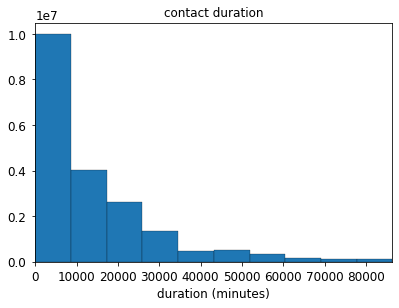

In [48]:
plt.hist(edge_attributes['duration'].values, edgecolor='k')
plt.xlim([edge_attributes['duration'].values.min(), edge_attributes['duration'].values.max()])
plt.xlabel('duration (minutes)')
plt.title('contact duration')
#plt.tight_layout()
plt.savefig("figures/contact_duration_hist.pdf", bbox_inches='tight')
plt.show()

The duration scales many order of magnitudes. Rather than plotting on a log scale, I want to bin the data according to:

- x < 1 min
- 1 min $\le$ x < 5 mins
- 5 mins $\le$ x < 10 mins
- 10 mins $\le$ x < 1 hour
- 1 hour $\le$ x < 2 hours
- 2 hours $\le$ x < 4 hours
- 4 hours $\le$ x < 8 hours
- 8 hours $\le$ x < 1 day

In [49]:
bins = [0, 60, 5*60, 10*60, 60*60, 2*60*60, 4*60*60, 8*60*60, 24*60*60]
duration_list = [0]*len(bins)
for i in range(len(edge_attributes)):
    duration = edge_attributes['duration'].iloc[i]
    
    if duration < bins[0]:
        duration_list[0] += 1
        
    elif duration < bins[1]:
        duration_list[1] += 1
 
    elif duration < bins[2]:
        duration_list[2] += 1        
    
    elif duration < bins[3]:
        duration_list[3] += 1
    
    elif duration < bins[4]:
        duration_list[4] += 1
    
    elif duration < bins[5]:
        duration_list[5] += 1        
    
    elif duration < bins[6]:
        duration_list[6] += 1        
    
    elif duration < bins[7]:
        duration_list[7] += 1   

    elif duration < bins[8]:
        duration_list[8] += 1      

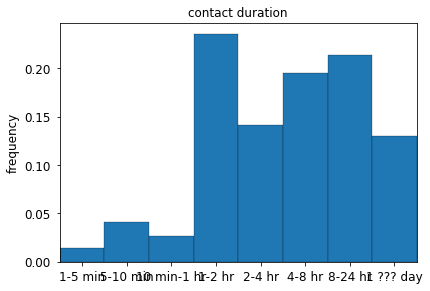

In [50]:
plt.bar(np.arange(9), np.asarray(duration_list)/np.sum(duration_list), width=1.0, edgecolor='k')
#plt.xlabel('duration (minutes)')
plt.xticks(np.arange(9), ['0-1 min', '1-5 min', '5-10 min', '10 min-1 hr', '1-2 hr', '2-4 hr', '4-8 hr', '8-24 hr', '1 ??? day'])
plt.ylabel('frequency')
plt.xlim([0.5, 8.5])
plt.title('contact duration')
#plt.tight_layout()
plt.savefig("figures/contact_duration_hist_modified.pdf", bbox_inches='tight')
plt.show()

In [51]:
activity_dict = {0:'home', 1:'work', 2:'shop', 3:'visit', 4:'social/recreation', 5:'other', 6:'pick-up/drop-off passenger', 7:'school', 8:'college'}
activity_dict

{0: 'home',
 1: 'work',
 2: 'shop',
 3: 'visit',
 4: 'social/recreation',
 5: 'other',
 6: 'pick-up/drop-off passenger',
 7: 'school',
 8: 'college'}

In [52]:
activity_count_dict = {(activity_dict[x], activity_dict[y]): 0 for x in range(len(activity_dict)) for y in range(x, len(activity_dict))}
activity_duration_dict = {(activity_dict[x], activity_dict[y]): 0 for x in range(len(activity_dict)) for y in range(x, len(activity_dict))}

for i in range(len(edge_attributes)):
    activityid1 = edge_attributes['activity1'].iloc[i]
    activityid2 = edge_attributes['activity2'].iloc[i]
    duration = edge_attributes['duration'].iloc[i]
    
    if activityid1 <= activityid2:
        activity_count_dict[(activity_dict[activityid1], activity_dict[activityid2])] += 1
        activity_duration_dict[(activity_dict[activityid1], activity_dict[activityid2])] += duration
    else:
        activity_count_dict[(activity_dict[activityid2], activity_dict[activityid1])] += 1
        activity_duration_dict[(activity_dict[activityid2], activity_dict[activityid1])] += duration

plot the contact frequency by number of contacts

In [53]:
values_count = np.asarray(list(activity_count_dict.values()))
keys_count = np.asarray(list(activity_count_dict.keys()))

## sort
values_count_sorted = -np.sort(-values_count)
keys_count_sorted = keys_count[np.argsort(-values_count)]

## remove 0 values
keys_count_sorted = keys_count_sorted[values_count_sorted > 0]
values_count_sorted = values_count_sorted[values_count_sorted > 0]

In [54]:
keys_count_sorted

array([['work', 'work'],
       ['school', 'school'],
       ['home', 'home'],
       ['other', 'other'],
       ['shop', 'shop'],
       ['college', 'college'],
       ['social/recreation', 'other'],
       ['social/recreation', 'social/recreation'],
       ['visit', 'other'],
       ['other', 'pick-up/drop-off passenger'],
       ['visit', 'social/recreation'],
       ['social/recreation', 'pick-up/drop-off passenger'],
       ['home', 'school'],
       ['visit', 'visit'],
       ['visit', 'pick-up/drop-off passenger'],
       ['pick-up/drop-off passenger', 'pick-up/drop-off passenger'],
       ['home', 'work'],
       ['home', 'college'],
       ['work', 'school']], dtype='<U26')

In [55]:
values_count_sorted

array([9046309, 2313956, 1851841, 1672898, 1376852, 1316398,  545632,
        493580,  251978,  202938,  154573,  150891,  142148,   79120,
         65638,   17024,      41,       3,       1])

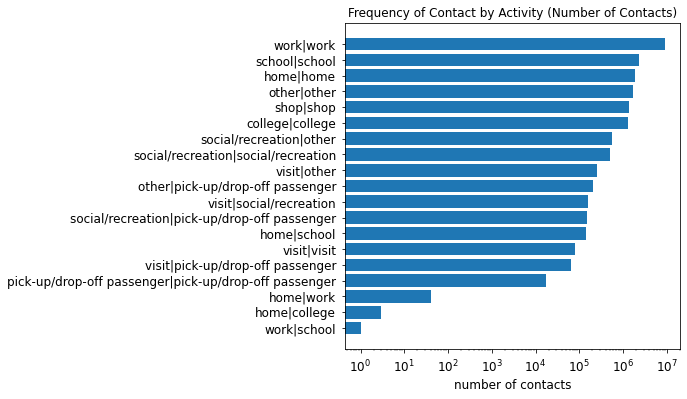

In [56]:
fig, ax = plt.subplots(figsize=(6,6))
y_pos = np.arange(len(values_count_sorted))
ax.barh(y_pos, values_count_sorted, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels([w[0] + '|' + w[1] for w in keys_count_sorted])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('number of contacts')
ax.set_title('Frequency of Contact by Activity (Number of Contacts)')
ax.set_xscale('log')
#plt.tight_layout()
plt.savefig("figures/contact_frequency_count.pdf", bbox_inches='tight')
plt.show()

plot the contact frequency by duration

In [57]:
values_duration = np.asarray(list(activity_duration_dict.values()))
keys_duration = np.asarray(list(activity_duration_dict.keys()))

## sort
values_duration_sorted = -np.sort(-values_duration)
keys_duration_sorted = keys_count[np.argsort(-values_duration)]

## remove 0 values
keys_duration_sorted = keys_duration_sorted[values_duration_sorted > 0]
values_duration_sorted = values_duration_sorted[values_duration_sorted > 0]

In [58]:
keys_duration_sorted

array([['work', 'work'],
       ['home', 'home'],
       ['school', 'school'],
       ['college', 'college'],
       ['other', 'other'],
       ['social/recreation', 'social/recreation'],
       ['shop', 'shop'],
       ['social/recreation', 'other'],
       ['home', 'school'],
       ['visit', 'other'],
       ['visit', 'social/recreation'],
       ['visit', 'visit'],
       ['other', 'pick-up/drop-off passenger'],
       ['social/recreation', 'pick-up/drop-off passenger'],
       ['visit', 'pick-up/drop-off passenger'],
       ['pick-up/drop-off passenger', 'pick-up/drop-off passenger'],
       ['home', 'work'],
       ['home', 'college'],
       ['work', 'school']], dtype='<U26')

In [59]:
values_duration_sorted

array([108236210223,  93550489942,  40612671129,  11128992027,
         4139285760,   2068368509,   1980957820,   1744374516,
         1248197904,    509229037,    376372181,    133139246,
          133113030,    100457221,     38375718,      5904782,
             361324,        18000,         9600])

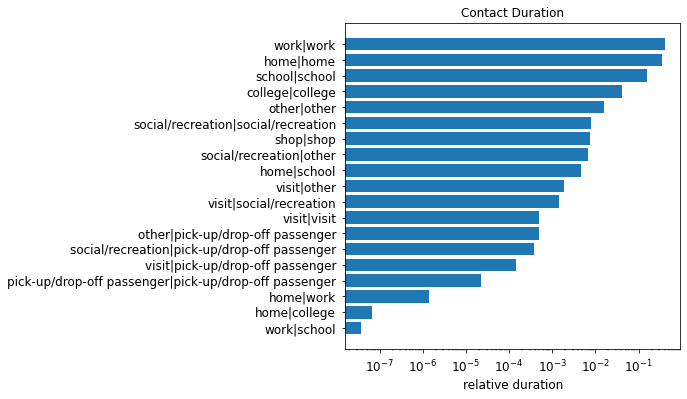

In [60]:
fig, ax = plt.subplots(figsize=(6,6))
y_pos = np.arange(len(values_duration_sorted))
ax.barh(y_pos, values_duration_sorted/np.sum(values_duration_sorted), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels([w[0] + '|' + w[1] for w in keys_duration_sorted])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('relative duration')
ax.set_title('Contact Duration')
ax.set_xscale('log')
#plt.tight_layout()
plt.savefig("figures/contact_frequency_duration.pdf", bbox_inches='tight')
plt.show()